## Notebook for hyperparameter-tuning for TimeGAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from models.data_generating_models.quant_gan import QuantGAN
import wandb

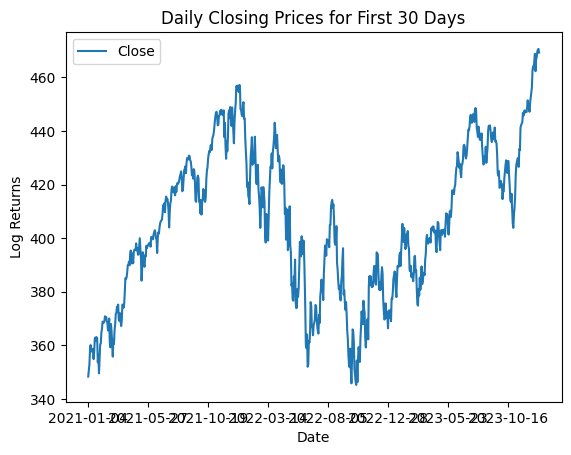

Log returns description: 
             Close
count  753.000000
mean   405.620456
std     28.325573
min    345.188599
25%    383.905823
50%    404.113434
75%    428.389099
max    470.652802


In [2]:
train_data = pd.read_csv("../data/raw/spy_daily_closing_prices.csv", index_col=0)

# i = 334
# train_data.iloc[i:i+30].plot(y='Close', use_index=True)
train_data.plot(y='Close', use_index=True)
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Daily Closing Prices for First 30 Days')
plt.show()

# train_data = np.log(train_data/train_data.shift(1)).dropna()
print("Log returns description: \n", train_data.describe())


N = 30
M = 1000
load_params = False

In [ ]:
hyperparameters = {
    "clip_value": 0.007, #0.01 default
    "lr": 0.0002,
    "num_epochs": 10,
    "nz": 3,
    "batch_size": 10,
    "seq_len": 30,
}
model = QuantGAN(train_data, N, M, load_params=False, config=hyperparameters)
model.fit_params_to_data()

model.generate_data()
print(f"Max: {np.max(model.synth_data.max())}")
print(f"Min: {np.min(model.synth_data.min())}")
print(f"Std: {np.mean(model.synth_data.std(axis=1))}")

Loss_D: -0.00001651 Loss_G: -0.50000167: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


Max: 0.011784163303673267
Min: -0.00666060671210289
Std: 0.0014867463614791632


(1000, 30)


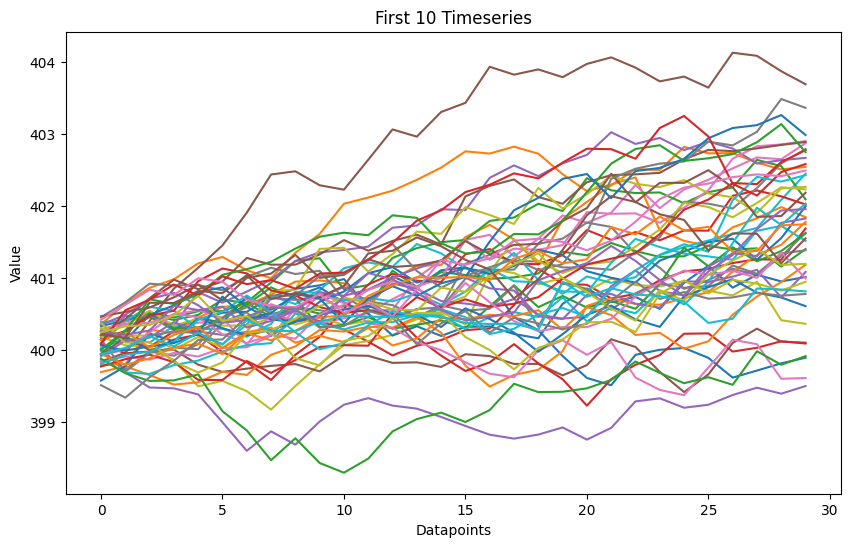

In [31]:
df = model.synth_data
df = 400 * np.exp(df)

print(df.shape)

# Plot the first 10 timeseries
plt.figure(figsize=(10, 6))
for i in range(50):
    plt.plot(df.iloc[i, :])
plt.xlabel('Datapoints')
plt.ylabel('Value')
plt.title('First 10 Timeseries')
plt.show()

# Create subplots for each of the first 10 timeseries
# fig, axs = plt.subplots(10, 1, figsize=(10, 20))
# for i in range(10):
#     axs[i].plot(df.iloc[i, :])
#     axs[i].set_title(f'Timeseries {i+1}')
#     axs[i].set_xlabel('Datapoints')
#     axs[i].set_ylabel('Value')
# plt.tight_layout()
# plt.show()